
# **Title**

# DTSA-5742 Final
### Visualizing and modeling hurricane data in Python

Alec Jeffery

Sept, 30th 2024

# **Abstract**


Hurricane Helene generated an enormous amount of digital data. One such data stream was collected from Saildrones at the ocean surface during the storm. We will see if we can can model behavior with the data available.

# **Contents**

1. Intro
2. Data Collection
3. Data Prep & cleaning
4. Methodology
5. Supervised Learning - KMeans
6. Unsupervised Learning - XGBOOST regression model & classification model
7. Results
8. Limitations
9. Conclusion
10. References

# 1. Introduction


Interestingly, as well as timely, the recent Hurricane in the gulf of the US was 'the most data tracked' hurricane in history. It is a marvel that storm data from less than 7 days prior to this report is avalable to amature researchers! I was able to find data at the following location:
https://www.pmel.noaa.gov/saildrone-hurricane/

Hurricanes are natural processes that are interconnected w/ climate modeling. The motivation of this project is to explore data and make some inferences by using machine learning (both supervised and un-supervised).

We will exclusively utilize data collected from an unmanned saildrone that drifted listlessly amidst sea during the atmospheric tempest.

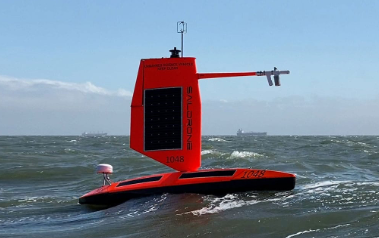

[Link](https://www.pmel.noaa.gov/saildrone-hurricane/) fior Saildrone project info

# 2. Data Gathering

In [39]:
!pip install requests pandas
import pandas as pd
url = "https://data.pmel.noaa.gov/generic/erddap/tabledap/sd1031_hurricane_2021.csv?latitude,longitude,time,trajectory,TEMP_AIR_MEAN,RH_MEAN,BARO_PRES_MEAN,TEMP_SBE37_MEAN,SAL_SBE37_MEAN,WATER_CURRENT_SPEED_MEAN,WATER_CURRENT_DIRECTION_MEAN,WAVE_DOMINANT_PERIOD,WAVE_SIGNIFICANT_HEIGHT&time>=2021-10-29T00:00:00Z&time<=2021-11-05T21:59:00Z"

# Load the data into a DataFrame
df = pd.read_csv(url)

print(len(df))


11401


# 3. Cleaning The Data

I will impute missing data values as the most recent datapoint for non-Nan values.

First, I will extract the units for all columns and then erase this row from the dataset. I will then fill in the missing values and then erase any leftover NaNs.


In [50]:
print('Raw Length of Data', len(df))

Units = df.iloc[0]
df = df.drop(df.index[0])
df.reset_index(drop=True, inplace=True)

df = df.fillna(method='ffill')

#  eliminate leftover NaN values
dff = df.dropna(axis=0, how = 'any')
print('Cleaned Length of Data', len(df))


Raw Length of Data 11400
Cleaned Length of Data 11399


<ipython-input-50-029300f75db5>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Next I will convert the datatypes to types that I will be able to work with

In [41]:
# Converting 'latitude' and 'longitude' to numeric
dff['latitude'] = pd.to_numeric(dff['latitude'], errors='coerce')
dff['longitude'] = pd.to_numeric(dff['longitude'], errors='coerce')

# Converting 'time' to a datetime type
dff['time'] = pd.to_datetime(dff['time'], errors='coerce')

# Converting other columns to numeric
columns_to_convert = ['TEMP_AIR_MEAN', 'RH_MEAN', 'BARO_PRES_MEAN',
                      'TEMP_SBE37_MEAN', 'WATER_CURRENT_SPEED_MEAN',
                      'WATER_CURRENT_DIRECTION_MEAN', 'WAVE_DOMINANT_PERIOD',
                      'WAVE_SIGNIFICANT_HEIGHT']

for col in columns_to_convert:
    dff[col] = pd.to_numeric(dff[col], errors='coerce')

# Display the data types to verify the changes
print(dff.dtypes)


<ipython-input-41-dba569de031a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['latitude'] = pd.to_numeric(dff['latitude'], errors='coerce')
<ipython-input-41-dba569de031a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['longitude'] = pd.to_numeric(dff['longitude'], errors='coerce')
<ipython-input-41-dba569de031a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

latitude                                    float64
longitude                                   float64
time                            datetime64[ns, UTC]
trajectory                                  float64
TEMP_AIR_MEAN                               float64
RH_MEAN                                     float64
BARO_PRES_MEAN                              float64
TEMP_SBE37_MEAN                             float64
SAL_SBE37_MEAN                              float64
WATER_CURRENT_SPEED_MEAN                    float64
WATER_CURRENT_DIRECTION_MEAN                float64
WAVE_DOMINANT_PERIOD                        float64
WAVE_SIGNIFICANT_HEIGHT                     float64
dtype: object


<ipython-input-41-dba569de031a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[col] = pd.to_numeric(dff[col], errors='coerce')


# **4. Methodology**

We'll begin this approach by looking for subtlable features for modeling & clustering algos. This can be performed by plotting several features at once.

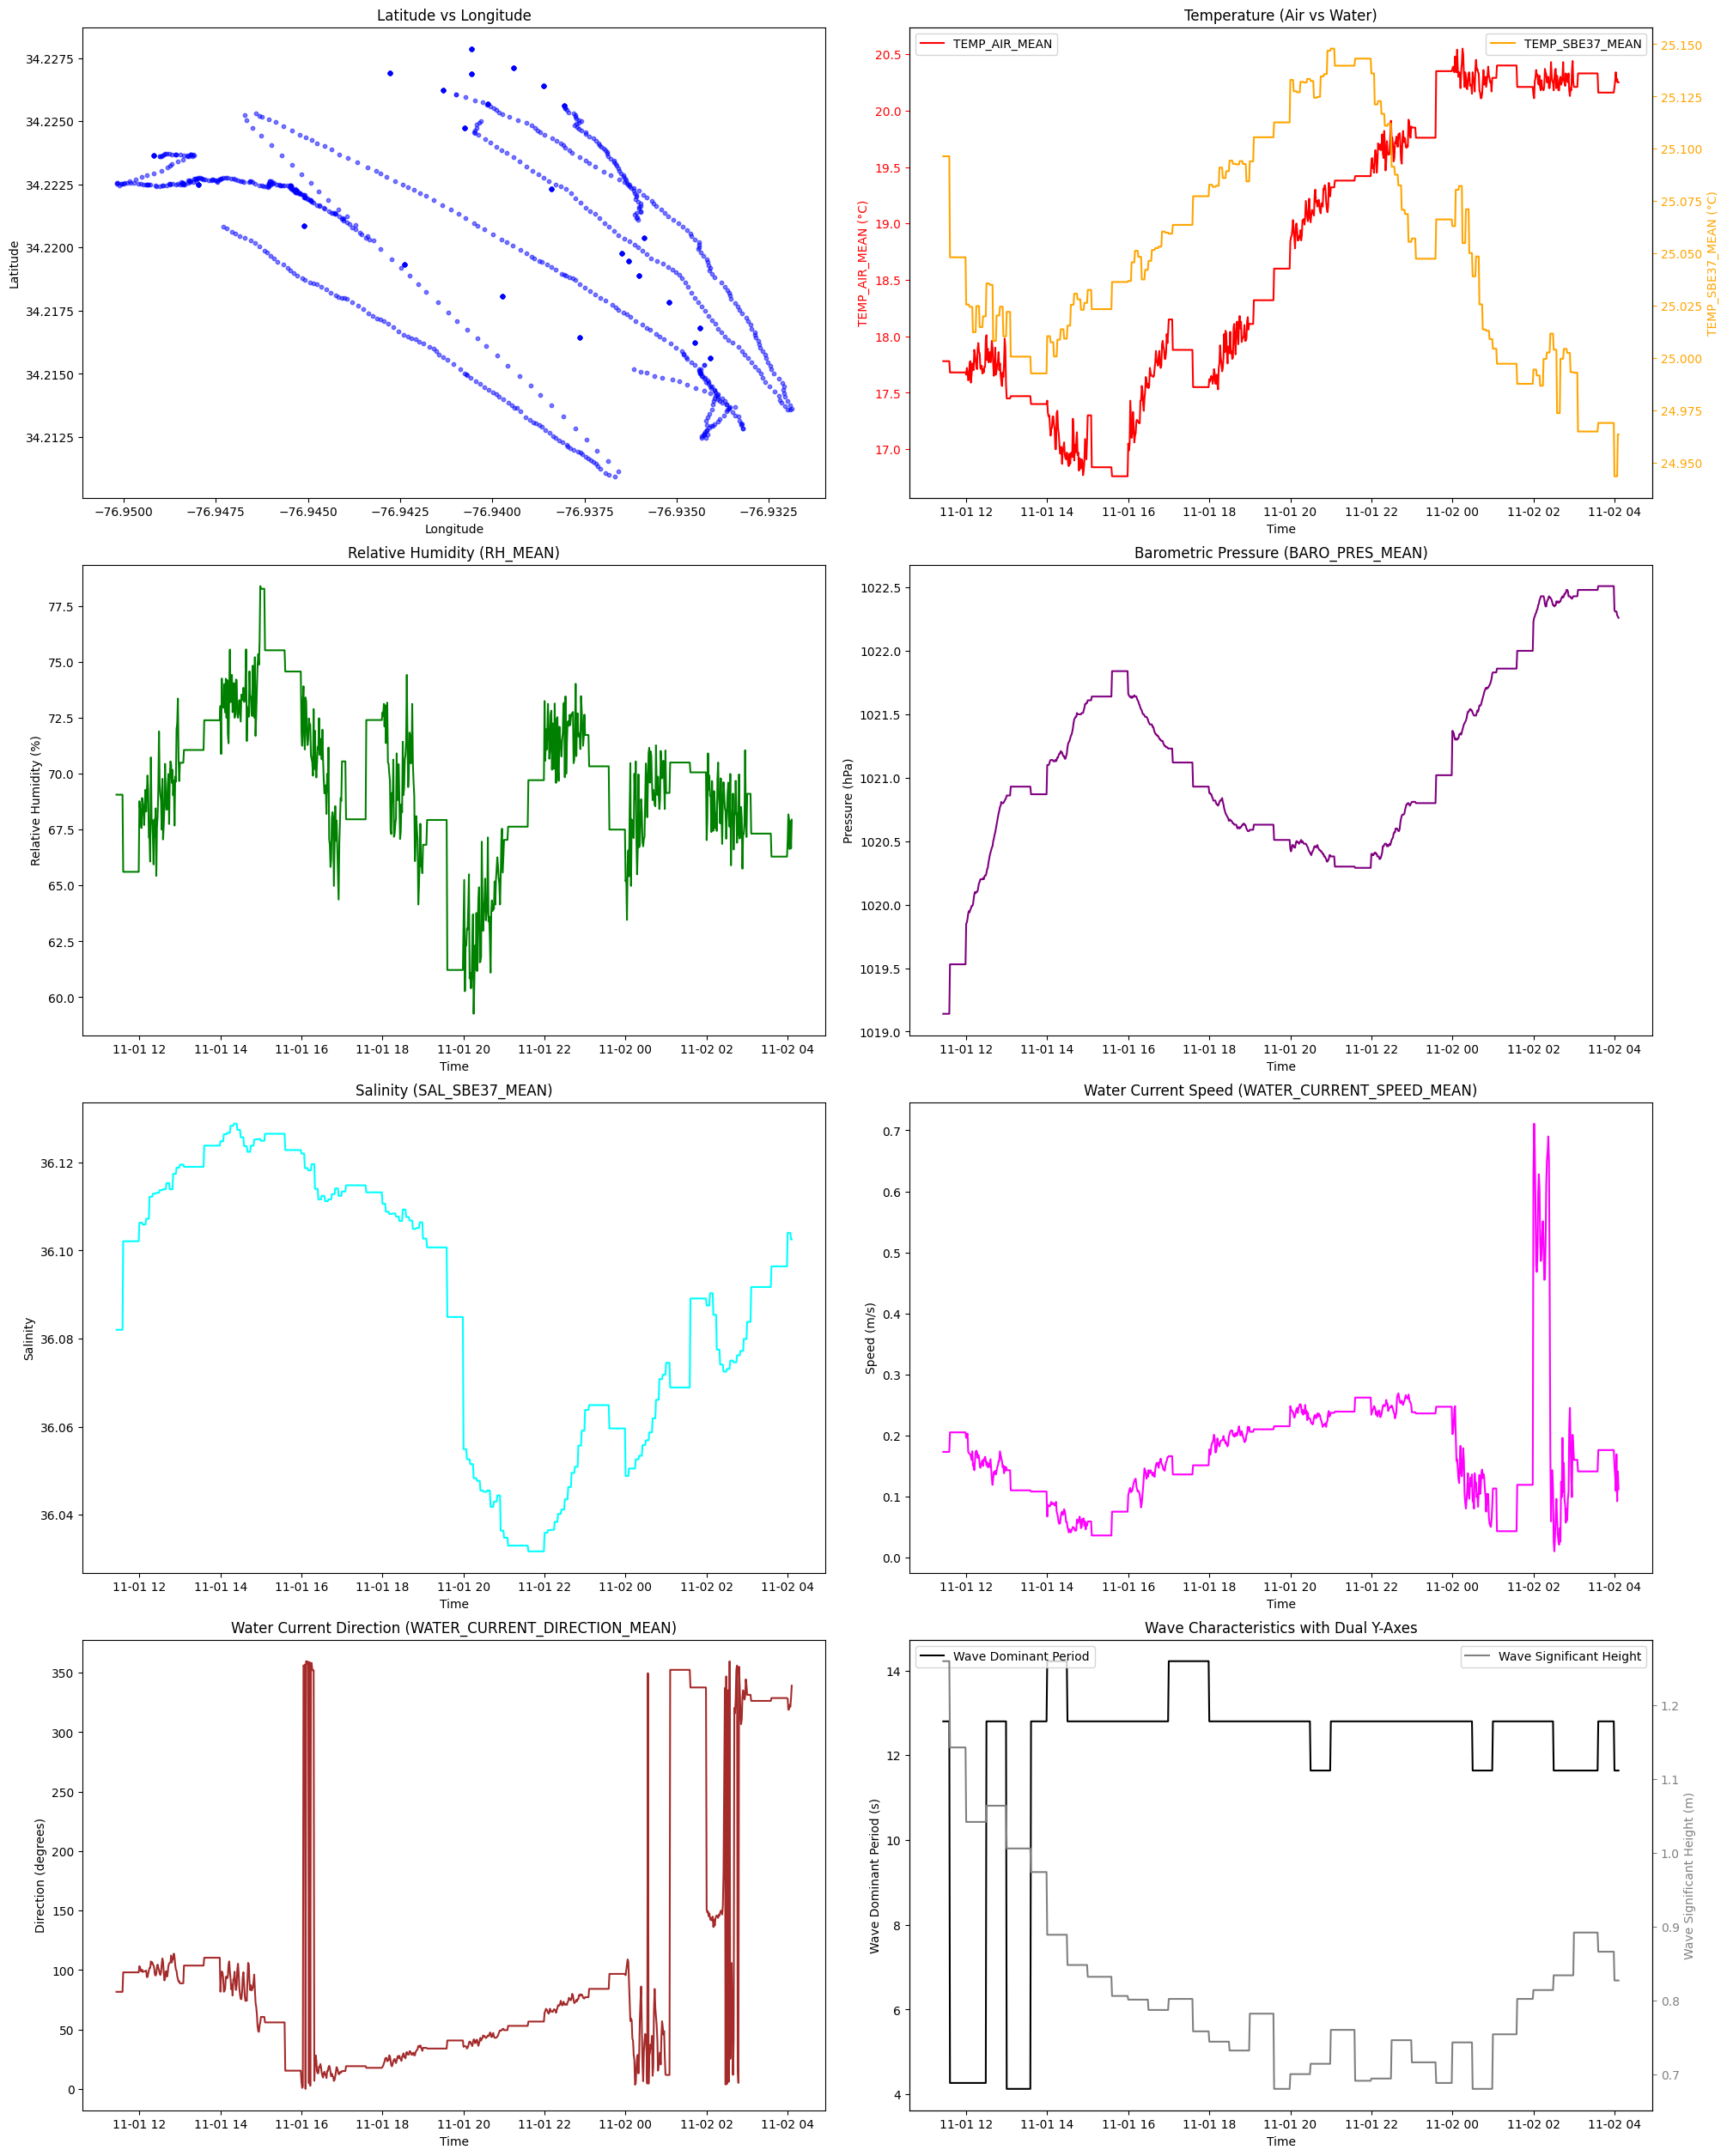

In [42]:
import matplotlib.pyplot as plt

# Create a figure with 8 subplots arranged in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(20, 25), constrained_layout=True)

# 1. Scatter plot of 'latitude' and 'longitude'
axes[0, 0].scatter(dff_subset['longitude'], dff_subset['latitude'], c='blue', alpha=0.5, s=10)
axes[0, 0].set_title('Latitude vs Longitude')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')

# 2. Line plot of 'TEMP_AIR_MEAN' and 'TEMP_SBE37_MEAN' with dual y-axes
ax_temp_air = axes[0, 1]
ax_temp_water = ax_temp_air.twinx()  # Create a twin y-axis

# Plot TEMP_AIR_MEAN on the left y-axis
ax_temp_air.plot(dff_subset['time'], dff_subset['TEMP_AIR_MEAN'], label='TEMP_AIR_MEAN', color='red')
ax_temp_air.set_ylabel('TEMP_AIR_MEAN (°C)', color='red')
ax_temp_air.tick_params(axis='y', colors='red')

# Plot TEMP_SBE37_MEAN on the right y-axis
ax_temp_water.plot(dff_subset['time'], dff_subset['TEMP_SBE37_MEAN'], label='TEMP_SBE37_MEAN', color='orange')
ax_temp_water.set_ylabel('TEMP_SBE37_MEAN (°C)', color='orange')
ax_temp_water.tick_params(axis='y', colors='orange')

# Set common title and x-label
ax_temp_air.set_title('Temperature (Air vs Water)')
ax_temp_air.set_xlabel('Time')

# Display legends for both y-axes
ax_temp_air.legend(loc='upper left')
ax_temp_water.legend(loc='upper right')

# 3. Line plot of 'RH_MEAN'
axes[1, 0].plot(dff_subset['time'], dff_subset['RH_MEAN'], color='green')
axes[1, 0].set_title('Relative Humidity (RH_MEAN)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Relative Humidity (%)')

# 4. Line plot of 'BARO_PRES_MEAN'
axes[1, 1].plot(dff_subset['time'], dff_subset['BARO_PRES_MEAN'], color='purple')
axes[1, 1].set_title('Barometric Pressure (BARO_PRES_MEAN)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure (hPa)')

# 5. Line plot of 'SAL_SBE37_MEAN'
axes[2, 0].plot(dff_subset['time'], dff_subset['SAL_SBE37_MEAN'], color='cyan')
axes[2, 0].set_title('Salinity (SAL_SBE37_MEAN)')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Salinity')

# 6. Line plot of 'WATER_CURRENT_SPEED_MEAN'
axes[2, 1].plot(dff_subset['time'], dff_subset['WATER_CURRENT_SPEED_MEAN'], color='magenta')
axes[2, 1].set_title('Water Current Speed (WATER_CURRENT_SPEED_MEAN)')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Speed (m/s)')

# 7. Line plot of 'WATER_CURRENT_DIRECTION_MEAN'
axes[3, 0].plot(dff_subset['time'], dff_subset['WATER_CURRENT_DIRECTION_MEAN'], color='brown')
axes[3, 0].set_title('Water Current Direction (WATER_CURRENT_DIRECTION_MEAN)')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('Direction (degrees)')

# 8. Line plot of 'WAVE_DOMINANT_PERIOD' and 'WAVE_SIGNIFICANT_HEIGHT' with dual y-axes
ax1 = axes[3, 1]  # Main axis
ax2 = ax1.twinx()  # Create a twin y-axis

ax1.plot(dff_subset['time'], dff_subset['WAVE_DOMINANT_PERIOD'], label='Wave Dominant Period', color='black')
ax2.plot(dff_subset['time'], dff_subset['WAVE_SIGNIFICANT_HEIGHT'], label='Wave Significant Height', color='gray')

ax1.set_title('Wave Characteristics with Dual Y-Axes')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wave Dominant Period (s)', color='black')
ax2.set_ylabel('Wave Significant Height (m)', color='gray')

# Adjust colors for labels to match the lines
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='y', colors='gray')

# Display the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


We can see the diversity of what the dataset is providing. Immediately, several features seem conducive to supervised learning whereas others are more appropriate for unsupervised learning.

**Supervised learning Ideas:**
Cluster Wave Dominant period & Wave significance. These features vary significantly over time and seem to experience 'zones' or 'regimes'. We will seek to accurately predict which cluster the wave data is in.

**Unsupervised learning Ideas:**
It will be interesting to see if we can use multiple features to predict Water velocity. For example, barometric pressure, water and air temperature, salinity and relative humidity might offer insights here. We will try to model this with XGBoost.


## 5. Cluster the Wave Data

First plot the wave data to see if it looks like there may be clusters in the data

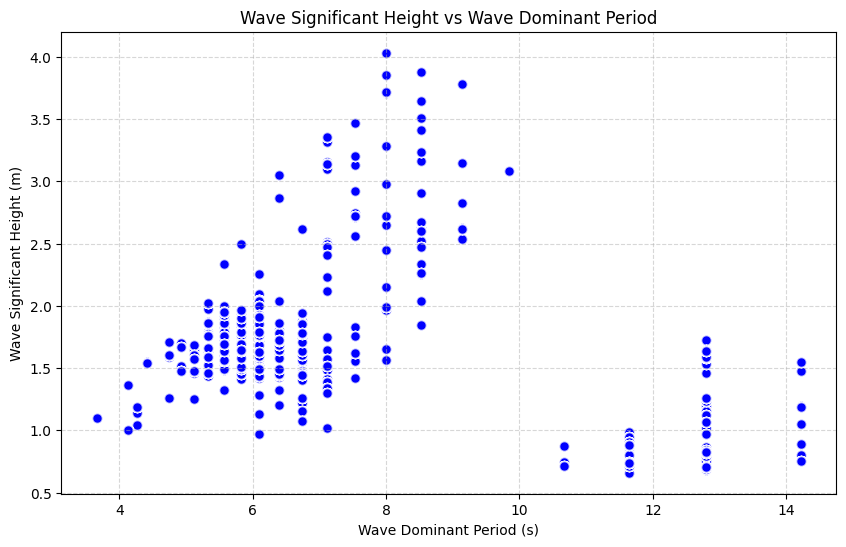

In [44]:

# Create a scatter plot for 'WAVE_SIGNIFICANT_HEIGHT' vs 'WAVE_DOMINANT_PERIOD'
plt.figure(figsize=(10, 6))
plt.scatter(dff['WAVE_DOMINANT_PERIOD'], dff['WAVE_SIGNIFICANT_HEIGHT'], alpha=0.6, c='blue', edgecolors='w', s=50)

# Set plot titles and labels
plt.title('Wave Significant Height vs Wave Dominant Period')
plt.xlabel('Wave Dominant Period (s)')
plt.ylabel('Wave Significant Height (m)')

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

True to our suspicion, there does look lke multiple clusters in the data. We will now see if we can generate 3 clusters with this data.


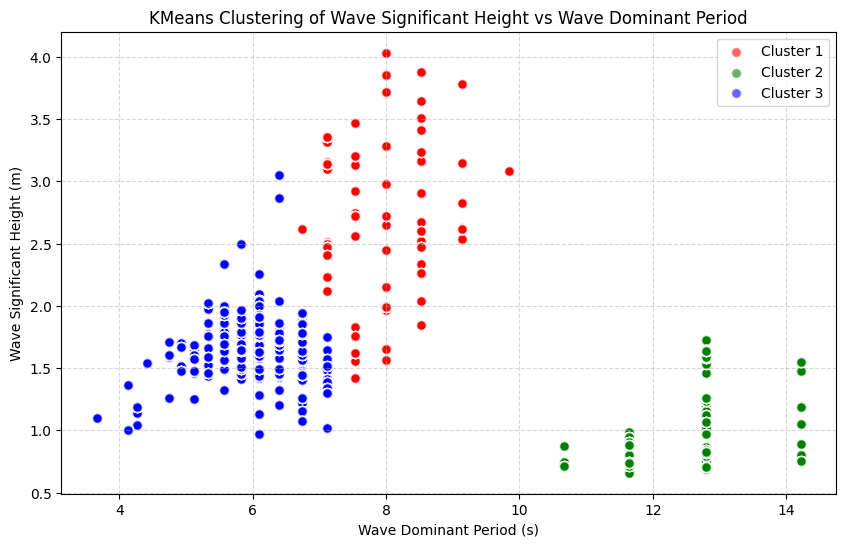

In [45]:
from sklearn.cluster import KMeans

# Extract the two features for clustering and drop missing values
X = dff[['WAVE_DOMINANT_PERIOD', 'WAVE_SIGNIFICANT_HEIGHT']].dropna()

# Perform KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the DataFrame
X['Cluster'] = kmeans.labels_

# Create a scatter plot with color coding for each cluster
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
colors = ['red', 'green', 'blue']
for cluster in range(3):
    subset = X[X['Cluster'] == cluster]
    plt.scatter(subset['WAVE_DOMINANT_PERIOD'], subset['WAVE_SIGNIFICANT_HEIGHT'],
                label=f'Cluster {cluster + 1}', alpha=0.6, s=50, edgecolors='w', c=colors[cluster])

# Set plot titles and labels
plt.title('KMeans Clustering of Wave Significant Height vs Wave Dominant Period')
plt.xlabel('Wave Dominant Period (s)')
plt.ylabel('Wave Significant Height (m)')

# Display the legend
plt.legend()

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Look at those clusters! Nice.

Let's use these for our subsequent tasks!

In [46]:
# Add these clusters to the dataset as they may be helpful later on!
dff.loc[X.index, 'Wave_Cluster'] = X['Cluster']


<ipython-input-46-63df15f2b721>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.loc[X.index, 'Wave_Cluster'] = X['Cluster']


## 6. Supervised learning
Now let's build a predictive model and evaluate performance of the model.

We will try to predict Water speed using: Barometric pressure, air and water temperature, salinity, cluster assignments, water directions and relative humidity.

I plan on using XGBoost regression to make these predictions. XGBoost is a boosted decision tree algorithm. Although we did not cover XGBoost in class, it is very similar to approached covered (namely, decision trees). The regression aspect is nice for fitting models to float data like we have.

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Features to be used
features = ['BARO_PRES_MEAN', 'TEMP_AIR_MEAN', 'TEMP_SBE37_MEAN', 'SAL_SBE37_MEAN',
            'Wave_Cluster', 'WATER_CURRENT_DIRECTION_MEAN', 'RH_MEAN']

# Target variable
target = 'WATER_CURRENT_SPEED_MEAN'

# Drop missing values and keep only relevant columns
data = dff[features + [target]].dropna()

# Splitting the features (X) and target variable (y)
X = data[features]
y = data[target]

# Split the dataset into 80/20 train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the standard scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the train data, transform the test data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model on the training set
xgb_reg.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
y_pred_scaled = xgb_reg.predict(X_test_scaled)

# Reverse the scaling on predictions to evaluate on the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


Root Mean Squared Error (RMSE) on test data: 0.029309802969636423


This root mean squared error is quite low. I'd like to see how this looks visually to understand what is happening here.

Let's make a plot!

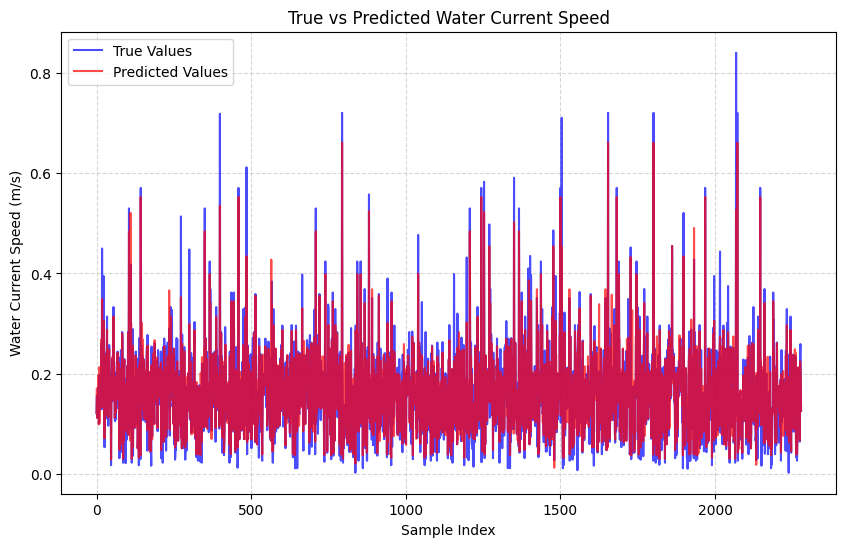

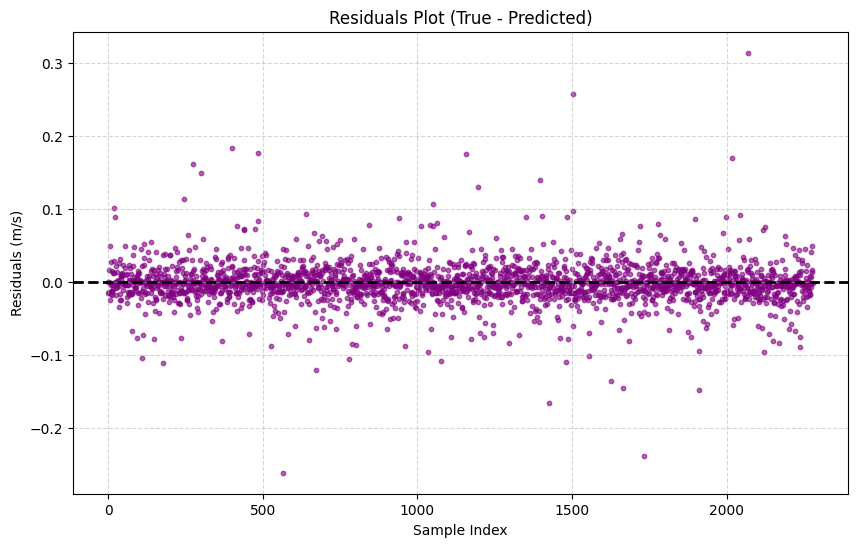

In [48]:

# Plot 1: True vs Predicted Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.7)
plt.title('True vs Predicted Water Current Speed')
plt.xlabel('Sample Index')
plt.ylabel('Water Current Speed (m/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot 2: Residuals Plot (y_true - y_pred)
residuals = y_test.values - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6, s=10)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.title('Residuals Plot (True - Predicted)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (m/s)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## **XGBoost classification**

To demonstrate the value of the xgboost library, we will see how accurate a clafficiation model is at predicting the wave period & height clusters from earlier (recall we used sklearn & kmeans to generate these clusters).

In [49]:
from sklearn.metrics import accuracy_score

# Use the same feature set as before
features = ['BARO_PRES_MEAN', 'TEMP_AIR_MEAN', 'TEMP_SBE37_MEAN', 'SAL_SBE37_MEAN',
            'WATER_CURRENT_DIRECTION_MEAN', 'RH_MEAN']

# Target variable: Wave Cluster assignment (based on wave height and period)
target = 'Wave_Cluster'

# Drop missing values and select only relevant columns from dff
data = dff[features + [target]].dropna()

# Splitting the features (X) and target variable (y)
X = data[features]
y = data[target]

# Split the dataset into 80/20 train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the standard scaler for feature scaling
scaler = StandardScaler()

# Fit and transform the train data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model on the training set
xgb_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test_scaled)

# Evaluate the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score on Test Data: {accuracy:.4f}")


Accuracy Score on Test Data: 0.9939


# **7. Results**

I am reiterating what has been visualized above.

Data was gathered from an online source at NOAA for a Hurricane that happened last week. The Hurricane Helene was monitored with a sail drone and generated tons of data. With this data I was able to make interesting observations.

The measurements on wave periodocity and height exhibit phase dependency that be depicted with an unsupervised learning algorithm. Kmeans cluster was specifically utilized. Visually, the clustering looks very reasonable.

Next, we sought to model wave speed by using multiple predictor features. To perform this, we first scaled the data and then used a boosted decision tree methodology also known as extreme gradiant boosted decision trees. The approach is significantly better than simple decision trees in the sklean package (honestly, go look at various examples online of XGBoost doing it's thing). With the XGB regressor, we achieved a rmse of < 0.03. When viewed visually, we can see that the predicted values track very well with the actual values.

I also used XGBoost classifier to predict which cluster the wave data is in. The classification model achieved 99.4% accuracy at predicting which wave regime the wave height and period were in. This is very good performance!

# **8. Conclusions**

The conclusion of this report is that Hurricane instrumentation/tracking provide a rich dataset for modeling both with supervised and unsupervised learning algorithms. We modeled wave speed by using other features and also assigned wave measurements into cogent classes that visually make sense.

# **9. Limitations**

One limitation that we did not explore and would be a worthwhile vein of inquiry is whether or not we can predict future states from current data. If we were to shift the wave velocity by 50 to 100 timesteps and then try to predict the future it would be very interesting! In this sense, the limitation is not enough data for advanced methods like LSTM dnn models or transformer models. Not to mention the time of building such a model and training it on a CPU as opposed to GPU!

# **10. References**

NOAA Pacific Marine Environmental Laboratory. (n.d.). Saildrone Hurricane Mission. Retrieved from https://www.pmel.noaa.gov/saildrone-hurricane/

NOAA Pacific Marine Environmental Laboratory. (n.d.). Saildrone Hurricane 2021 Data. Retrieved from https://data.pmel.noaa.gov/generic/erddap/tabledap/sd1031_hurricane_2021.htmlTable?latitude%2Clongitude%2Ctime%2Ctrajectory%2CTEMP_AIR_MEAN%2CRH_MEAN%2CBARO_PRES_MEAN%2CTEMP_SBE37_MEAN%2CSAL_SBE37_MEAN%2CWATER_CURRENT_SPEED_MEAN%2CWATER_CURRENT_DIRECTION_MEAN%2CWAVE_DOMINANT_PERIOD%2CWAVE_SIGNIFICANT_HEIGHT&time%3E=2021-10-29T00%3A00%3A00Z&time%3C=2021-11-05T21%3A59%3A00Z